In [22]:
import os
import h5py
import json
import numpy as np
from numpy import linalg as la
from scipy.linalg import eigh as largest_eigh
from dppy.finite_dpps import FiniteDPP
#Upgrade from v0.19.0 to v0.22.0
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from numpy.random import rand, randn, RandomState
from dppy.finite_dpps import FiniteDPP
from dppy.utils import example_eval_L_linear

In [23]:
sensor_json_path = '/beegfs/sk7898/nodes.json'
feats_path = '/beegfs/work/sonyc/features/openl3/2017/' #Ex: sonycnode-b827eb132382.sonyc_features_openl3.h5

# Load the json file with all nodes' information
with open(sensor_json_path, 'r') as f:
    datastore = json.load(f)

sensor_feats_list = [s.split('_')[0] for s in os.listdir(feats_path)]
sensors_list = []
sensors_loc = []

# Get the latitude and longitude of the sensors from which l3 features were extracted given:
# 1. l3 feature file has size > 1432 (is not blank)
# 2. latitude and longitude values are present in the json file
for sensor_data in datastore:
    sensor = sensor_data['fqdn'] 
    if sensor in sensor_feats_list:
        feat_size = os.path.getsize(os.path.join(feats_path, sensor + '_features_openl3.h5'))
        if sensor_data['latitude'] and sensor_data['longitude'] and feat_size > 6585176:
            sensors_list.append(sensor)
            sensors_loc.append([radians(sensor_data['latitude']), radians(sensor_data['longitude'])])
        elif feat_size > 1432:
            print('Latitude and/or Longitude not present for {} of size {}'.format(sensor, feat_size))

Latitude and/or Longitude not present for sonycnode-b827ebfd616c.sonyc of size 6585176
Latitude and/or Longitude not present for sonycnode-b827eb2c65db.sonyc of size 11211189038


In [24]:
# haversine_distances: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
L = haversine_distances(np.array(sensors_loc), np.array(sensors_loc))
                        
# In DPP, L is similarity matrix. So, higher L_ij implies lower probability of both i and j to be selected in the subset
# In our case, the lower the distance between two sensors, lower is the chance of both i and j to be there in the subset

# Reciprocate the haverstein_distances to conform with the way DPP operates on the Likelihood kernel
# Since L_ii = 0, add epsilon to avoid divide-by-zero error
L = 1/(L + 1e-15)

In [25]:
# Sample 10 sensors out of 24 
k = 10

DPP = FiniteDPP('likelihood', **{'L': L})
#DPP.plot_kernel()
DPP.flush_samples()
DPP.sample_mcmc_k_dpp(size=k)
print(DPP.list_of_samples)

[[[19, 1, 0, 2, 22, 23, 21, 11, 18, 4], [19, 1, 0, 2, 22, 23, 21, 11, 18, 4], [19, 1, 0, 2, 22, 23, 21, 11, 18, 4], [19, 1, 0, 2, 22, 16, 21, 11, 18, 4], [19, 1, 0, 2, 22, 16, 21, 11, 17, 4], [19, 1, 0, 2, 22, 16, 21, 11, 17, 4], [19, 1, 0, 2, 22, 16, 21, 11, 17, 10], [19, 1, 0, 2, 22, 16, 21, 11, 17, 10], [20, 1, 0, 2, 22, 16, 21, 11, 17, 10], [20, 1, 0, 2, 22, 16, 21, 9, 17, 10]]]


In [26]:
# From the list of subsets, pick one subset
subset = DPP.list_of_samples[0][0] 

sampled_sensors = [sensors_list[i] for i in subset]
sampled_distances = [sensors_loc[i] for i in subset]
print(sampled_sensors)

for sensor_data in datastore:
    sensor = sensor_data['fqdn'] 
    if sensor in sampled_sensors:
        print(sensor_data)

['sonycnode-b827eb815321.sonyc', 'sonycnode-b827ebf31214.sonyc', 'sonycnode-b827eb905497.sonyc', 'sonycnode-b827eb539980.sonyc', 'sonycnode-b827eb4cc22e.sonyc', 'sonycnode-b827eb5895e9.sonyc', 'sonycnode-b827ebad073b.sonyc', 'sonycnode-b827eb0fedda.sonyc', 'sonycnode-b827eb29eb77.sonyc', 'sonycnode-b827eb42bd4a.sonyc']
{'title': 'Kimmel Center', 'ap': 'nyu', 'cpu_load_1': '1.40', 'cpu_load_5': '1.26', 'cpu_load_15': '1.12', 'cpu_temp': '31.5', 'cpu_cur_freq': '900000000', 'date_up': '2016-12-10T01:00:00', 'langcode': 'On', 'switch': '', 'fqdn': 'sonycnode-b827eb905497.sonyc', 'branch': 'master', 'commit_date': '2018-04-13 12:06:11 -0400', 'nid': '28', 'ingestion_server': 'ingestion2-sonyc', 'last_update': '2018-12-14T12:29:17', 'life_stage': 'Active', 'cpu_max_freq': '', 'mem_available': '859127808', 'mem_percent': 11.5, 'mem_used': '452042752', 'nodeid': 'e84e067a3537', 'rx_packets': '413127651', 'tx_packets': '1330281843', 'disk_part': '', 'path': 'https://control-sonyc.engineering.n

**Plot the distance matrix of all the 24 sensors**

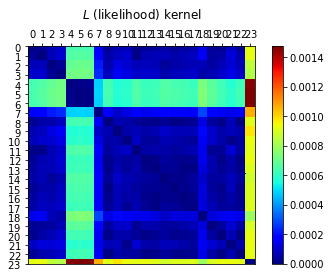

In [18]:
DPP.flush_samples()
L_orig = haversine_distances(np.array(sensors_loc), np.array(sensors_loc))
DPP = FiniteDPP('likelihood', **{'L': L_orig})
DPP.plot_kernel()

**Plot the distance matrix of the sampled sensors**

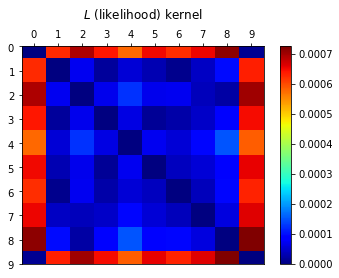

In [19]:
L_new = haversine_distances(np.array(sampled_distances), np.array(sampled_distances))
DPP = FiniteDPP('likelihood', **{'L': L_new})
DPP.plot_kernel()

In [8]:
# Add sonycnode-b827eb2c65db.sonyc in the subset